In [1]:
import os

from dotenv import load_dotenv

import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings



from IPython.display import display

load_dotenv()
project_id = os.getenv("PROJECT_ID")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

TOWERS = ["tower_A", "tower_B", "tower_C", "tower_D"]
METRIC = "lte_signal_to_noise_ratio"

**NOTE**: See the profiled `ltv_signal_to_noise_ratio` [here](https://storage.googleapis.com/anduril-case-study/metrics/lte_signal_to_noise_ratio.html).

In [2]:
# Get data
df = pandas_gbq.read_gbq(
    f"select * from metrics.{METRIC}",
    project_id=project_id,
    use_bqstorage_api=True,
)

query = f"""
select
  ts,
  tower_id,
  metric_name,
  metric_value
from `raw_data.long_clean`
where metric_name = '{METRIC}'
"""
df_long_clean = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    use_bqstorage_api=True,
)

df.set_index("ts", inplace=True)
df.drop(columns=["timestamp_ms"], inplace=True)
df.sort_index(inplace=True)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88339 entries, 2024-01-18 04:48:30+00:00 to 2024-02-17 20:57:30+00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tower_A  86105 non-null  float64
 1   tower_B  21539 non-null  float64
 2   tower_C  20654 non-null  float64
 3   tower_D  21437 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB


In [4]:
df.describe()

,tower_A,tower_B,tower_C,tower_D
count,86105.000000,21539.000000,20654.000000,21437.000000
mean,5.208308,2.255635,-0.309653,4.526733
std,2.068994,2.522206,2.210387,2.361138
min,-4.000000,-5.171429,-7.841667,-2.663636
25%,3.766667,1.016667,-1.608333,3.191667
50%,5.300000,2.241667,-0.166667,4.200000
75%,6.633333,3.675000,1.125000,5.233333
max,13.900000,9.375000,8.752174,19.641667


In [5]:
df['day'] = df.index.date
df_long = df.melt('day', TOWERS)
df.drop('day', axis=1, inplace=True)
df_long_avgs = df_long.merge(df.mean().rename('mean'), left_on='variable', right_index=True)

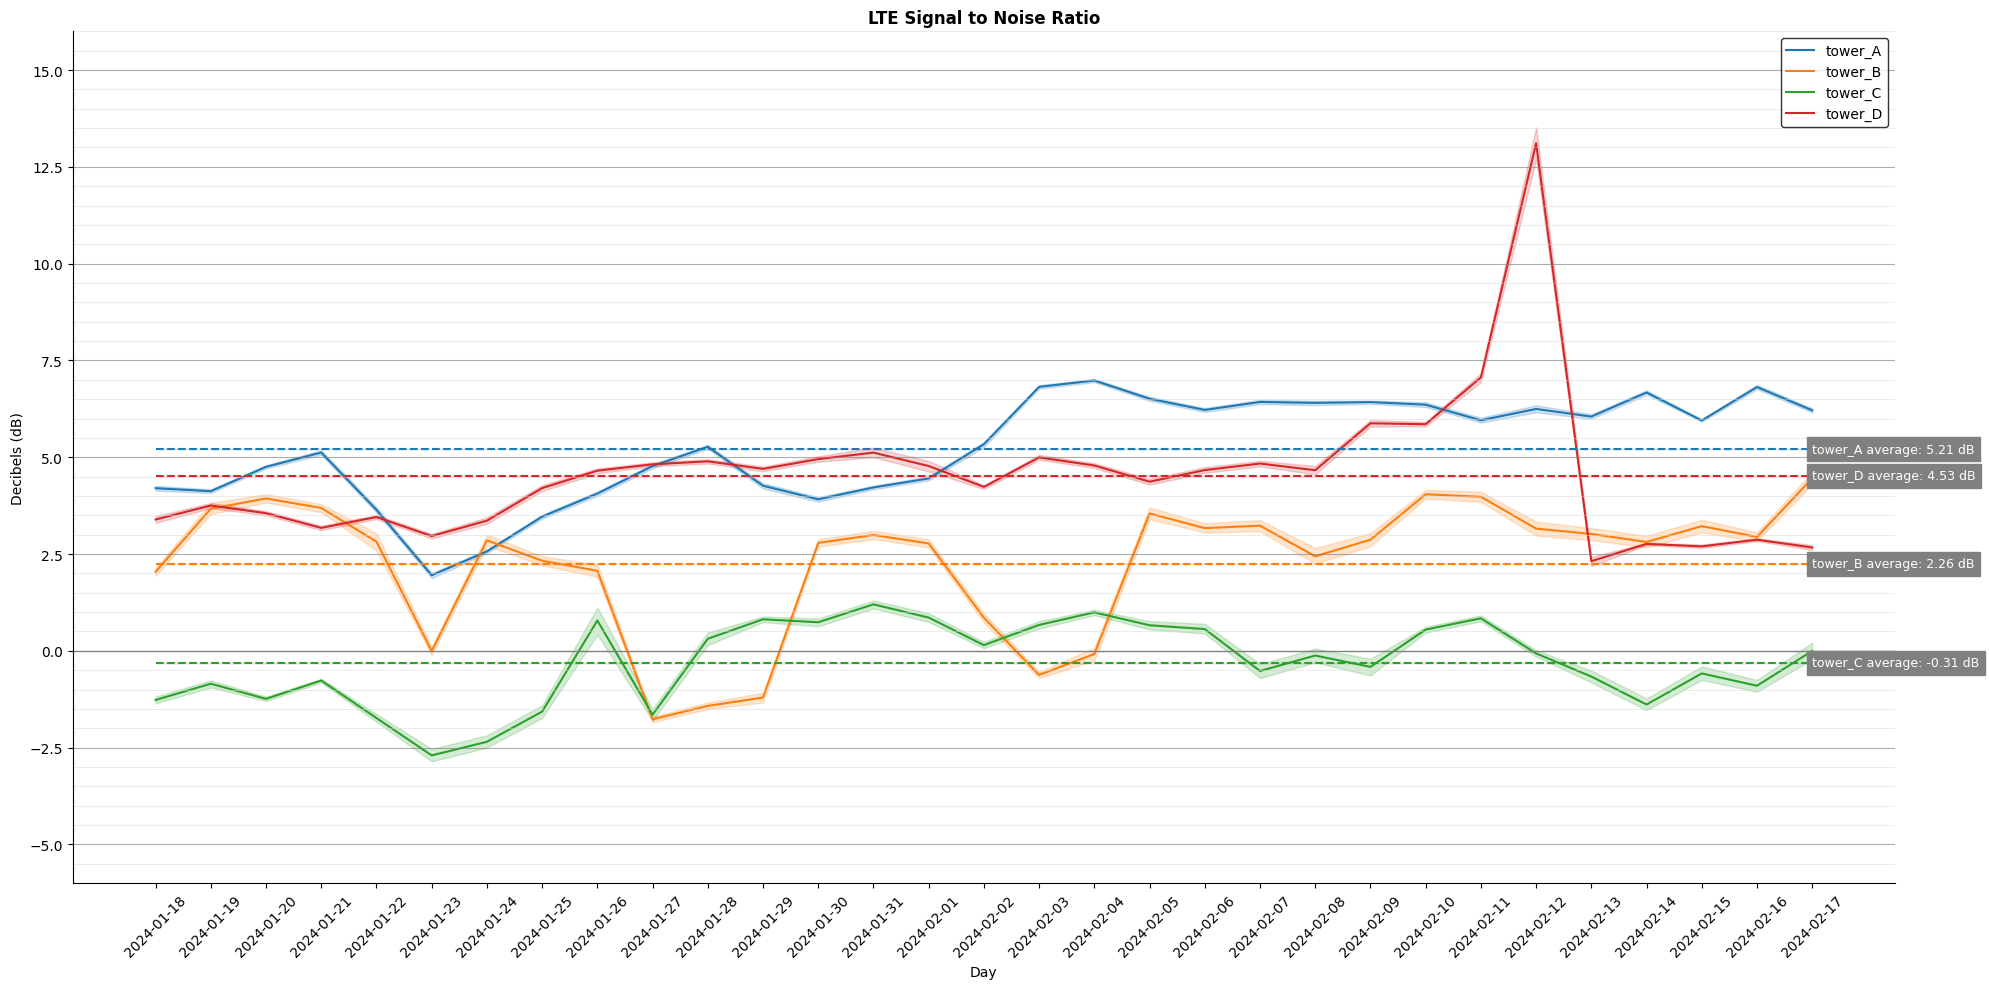

In [6]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='day', y='value', hue='variable', data=df_long)
ax = sns.lineplot(x='day', y='mean', hue='variable', linestyle='--', legend=False, data=df_long_avgs, ax=ax)

for tower in TOWERS:
    mean_value = df_long_avgs[df_long_avgs['variable'] == tower]['mean'].iloc[0]
    ax.text(x=df_long['day'].max(), y=mean_value, s=f'{tower} average: {mean_value:.2f} dB', 
            color='white', va='center', ha='left', fontsize=9).set_backgroundcolor('grey')

ax.minorticks_on()
for y in ax.get_yticks():
    lw, a = (0.8, 0.65) if y != 0 else (1, 1)
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=lw, alpha=a)
for y in ax.get_yticks(minor=True):
    ax.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.65)
ax.minorticks_off()

ax.set_xticks(x_values := df_long['day'].unique())
ax.set_xticklabels(x_values, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('LTE Signal to Noise Ratio', weight='bold')
plt.xlabel('Day')
plt.ylabel('Decibels (dB)')
plt.tight_layout()
plt.legend(title='Tower', )
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

In [8]:
df.resample('1d').agg(['mean', 'sem', 'std'])

tower_A                       tower_B            \
                               mean       sem       std      mean       sem   
ts                                                                            
2024-01-18 00:00:00+00:00  4.200702  0.033325  1.598882  2.042734  0.052685   
2024-01-19 00:00:00+00:00  4.123461  0.025904  1.390175  3.672375  0.072870   
2024-01-20 00:00:00+00:00  4.752928  0.022491  1.206987  3.935523  0.057060   
2024-01-21 00:00:00+00:00  5.121400  0.032369  1.737106  3.690231  0.054558   
2024-01-22 00:00:00+00:00  3.641140  0.038039  2.041411  2.820090  0.110508   
2024-01-23 00:00:00+00:00  1.952118  0.034494  1.851143 -0.004113  0.056348   
2024-01-24 00:00:00+00:00  2.568235  0.023956  1.285625  2.853359  0.067963   
2024-01-25 00:00:00+00:00  3.466424  0.027218  1.460671  2.327552  0.061915   
2024-01-26 00:00:00+00:00  4.062288  0.027796  1.489629  2.067292  0.083194   
2024-01-27 00:00:00+00:00  4.772847  0.029686  1.593109 -1.768208  0.037109   
2024-01-28 00:00:00+00:00  5.269925  0.026996  1.448772 -1.421571  0.043676   
2024-01-29 00:00:00+00:00  4.264601  0.034547  1.854001 -1.205674  0.063956   
2024-01-30 00:00:00+00:00  3.914218  0.030593  1.641512  2.787624  0.049473   
2024-01-31 00:00:00+00:00  4.220162  0.025009  1.342130  2.992655  0.053877   
2024-02-01 00:00:00+00:00  4.452009  0.027076  1.452547  2.773728  0.051160   
2024-02-02 00:00:00+00:00  5.335782  0.034642  1.858758  0.854223  0.062137   
2024-02-03 00:00:00+00:00  6.818027  0.025761  1.382503 -0.622996  0.041904   
2024-02-04 00:00:00+00:00  6.981840  0.020813  1.116921 -0.080825  0.089405   
2024-02-05 00:00:00+00:00  6.510841  0.028548  1.531505  3.547747  0.077478   
2024-02-06 00:00:00+00:00  6.221969  0.026762  1.435228  3.169353  0.057580   
2024-02-07 00:00:00+00:00  6.427984  0.029178  1.565605  3.232853  0.075211   
2024-02-08 00:00:00+00:00  6.404721  0.029074  1.496979  2.440727  0.098812   
2024-02-09 00:00:00+00:00  6.424167  0.022722  1.219395  2.870091  0.090285   
2024-02-10 00:00:00+00:00  6.357153  0.032977  1.769707  4.044384  0.056037   
2024-02-11 00:00:00+00:00  5.953977  0.033774  1.812169  3.979456  0.067312   
2024-02-12 00:00:00+00:00  6.247367  0.045302  2.431149  3.157019  0.089678   
2024-02-13 00:00:00+00:00  6.050332  0.031392  1.682608  3.019083  0.076250   
2024-02-14 00:00:00+00:00  6.672344  0.032216  1.728870  2.812103  0.075513   
2024-02-15 00:00:00+00:00  5.949827  0.016490  0.879063  3.221537  0.082273   
2024-02-16 00:00:00+00:00  6.813154  0.029568  1.586787  2.941121  0.058224   
2024-02-17 00:00:00+00:00  6.211092  0.027900  0.670177  4.458270  0.082046   

                                      tower_C                        tower_D  \
                                std      mean       sem       std       mean   
ts                                                                             
2024-01-18 00:00:00+00:00  0.856027 -1.268075  0.044485  0.460157   3.391592   
2024-01-19 00:00:00+00:00  1.955309 -0.849397  0.048455  1.300190   3.753315   
2024-01-20 00:00:00+00:00  1.531074 -1.239873  0.028416  0.762487   3.555199   
2024-01-21 00:00:00+00:00  1.463952 -0.767233  0.025216  0.676606   3.175848   
2024-01-22 00:00:00+00:00  2.965252 -1.735141  0.051092  1.330353   3.456572   
2024-01-23 00:00:00+00:00  1.509871 -2.700464  0.082091  2.202729   2.964991   
2024-01-24 00:00:00+00:00  1.823641 -2.348411  0.083022  2.227721   3.362911   
2024-01-25 00:00:00+00:00  1.661364 -1.569211  0.080112  2.149620   4.203400   
2024-01-26 00:00:00+00:00  2.230787  0.783633  0.174670  4.683634   4.653480   
2024-01-27 00:00:00+00:00  0.995752 -1.650534  0.078939  2.118158   4.817086   
2024-01-28 00:00:00+00:00  1.171954  0.312783  0.081229  2.147579   4.894448   
2024-01-29 00:00:00+00:00  1.716112  0.814837  0.037526  0.971349   4.699635   
2024-01-30 00:00:00+00:00  1.327497  0.738595  0.051809  1.297285   4.951546   
2024-01-31 00:00:00+00:00  1.445668  1.200192  0.054430  1.35